#1. Группа сетей Yolo v5

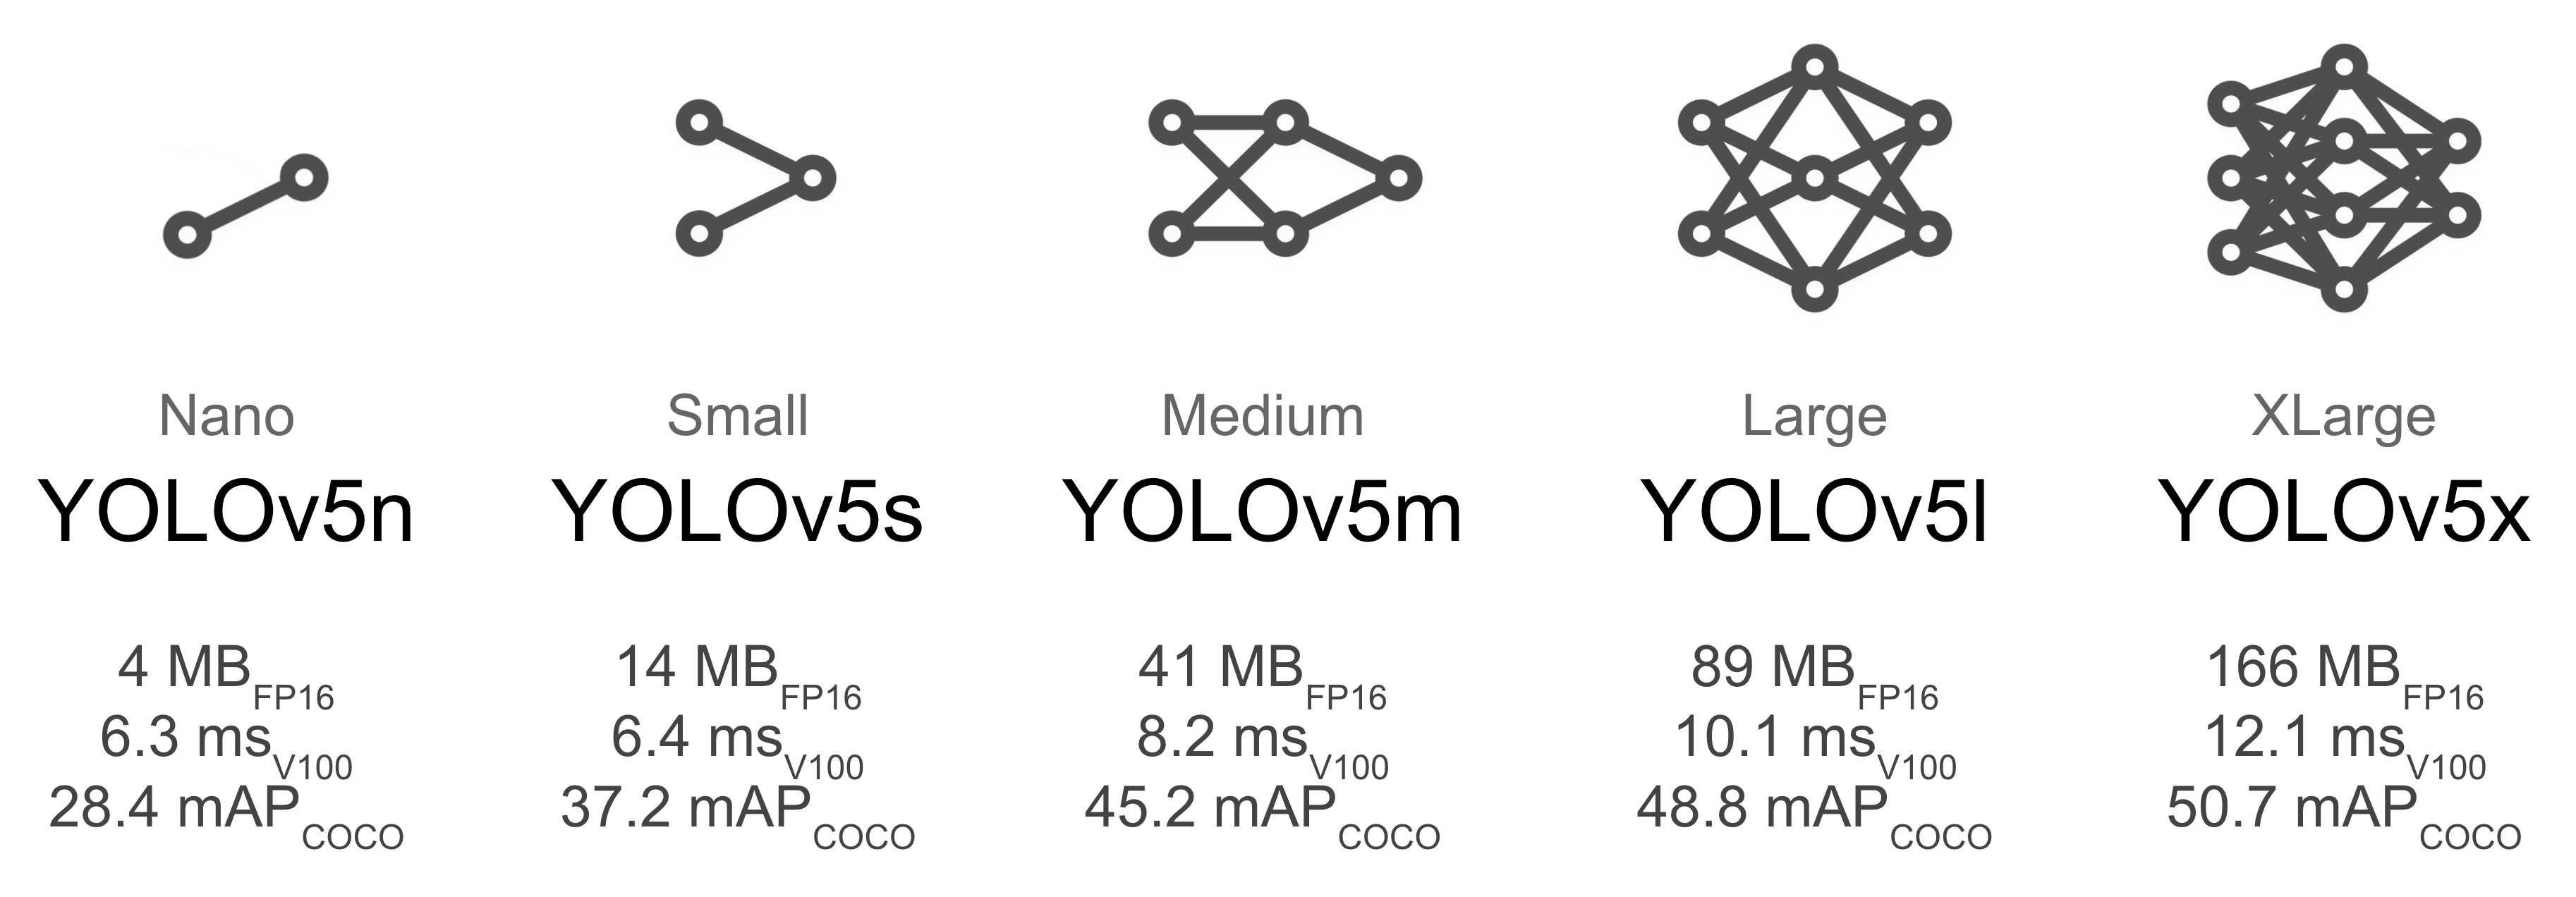

In [ ]:
!pip install torchvision==0.13.0
!pip install torch==1.12.0

In [2]:
import torch
from PIL import Image, ImageGrab
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

In [3]:
print(torch.version.__version__)

1.12.0+cu102


In [ ]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5l', pretrained=True)

img_path = '/content/we.jpg'
imgs = Image.open(img_path) 

### Настройки вывода

In [8]:
yolo_model.conf = 0.3  # порог уверенности модели для фильтрации предсказаний 
yolo_model.iou = 0.4  # пороговое значение NMS IoU
yolo_model.agnostic = False  # обнаружение объектов, не зависящих от класса
yolo_model.multi_label = False  # несколько классов на один bbox
yolo_model.classes = [0]  # выбор классов из COCO датасета, нулевой класс = persons
yolo_model.max_det = 10  # максимальное количество обнаружений на одно изображение
yolo_model.amp = True  # атоматический вывод смешанной точности

In [9]:
%%time

yolo_results = yolo_model(imgs)
yolo_results.print()
yolo_results.save() 

image 1/1: 1280x962 2 persons
Speed: 15.6ms pre-process, 1738.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)
Saved 1 image to runs/detect/exp2


CPU times: user 1.77 s, sys: 44.2 ms, total: 1.81 s
Wall time: 1.83 s


In [10]:
coordinates = yolo_results.xyxy[0][:, :4]
yolo_results.pandas().xyxy[0] 

xmin        ymin        xmax         ymax  confidence  class    name
0    0.000000    2.623840  962.000000  1274.183838    0.694743      0  person
1  719.677368  277.318481  960.874756   740.245056    0.430626      0  person

## Resume
➕Плюсы: самая быстрая, точная и легко запускающаяся модель; широкий выбор параметров настройки вывода

➖Минусы: низкая уверенность модели в прогнозах; может возникать ошибка в несоответствии версий библиотек torch и torchvision.

## Сравнение версий
### ✅yolov5s 
Уверенность: 0,37

Скорость: 7.2ms pre-process, 341.7ms inference, 1.4ms NMS per image, **total: 476 ms** 
### ✅yolov5m
Уверенность: 0,68

Скорость: 31.0ms pre-process, 897.9ms inference, 1.7ms NMS per image, **total: 1 s**
### ✅yolov5l
Уверенность: 0,69

Скорость: 15.6ms pre-process, 1738.0ms inference, 2.4ms NMS per image, **total:1.81 s**

🏅Обнаружила второго человека по половинке лица с уверенностью 0,43

### ✅yolov5x
Уверенность: 0,72

Скорость: 62.9ms pre-process, 3440.3ms inference, 1.6ms NMS per image, **total:3.53 s**

🏅Обнаружила второго человека по половинке лица с уверенностью 0,32

#2. Группа сетей Faster R-CNN

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
import urllib
from torchvision import transforms
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import pil_to_tensor

In [ ]:
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
resnet_model = fasterrcnn_resnet50_fpn_v2(weights=weights, pretrained=True, progress=False)
resnet_model.eval()
preprocess = weights.transforms()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


In [ ]:
img_path = '/content/we.jpg'
img = read_image(img_path)

batch = [preprocess(img)]

In [ ]:
weights.meta["categories"] = weights.meta["categories"][0:2]
weights.meta["categories"]

['__background__', 'person']

In [ ]:
%%time
prediction = resnet_model(batch)[0]
prediction["boxes"] = prediction["boxes"][prediction["scores"] > 0.96]
prediction["labels"] = prediction["labels"][prediction["scores"] > 0.96]
prediction["scores"] = prediction["scores"][prediction["scores"] > 0.96]

labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="cyan",
                          width=2, 
                          font_size = 30)

res = Image.fromarray(box.permute(1, 2, 0).contiguous().numpy())
res.save("bbox_faster.png") #сохранение задетекченного изображения

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:237: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


CPU times: user 13.1 s, sys: 447 ms, total: 13.6 s
Wall time: 14.8 s


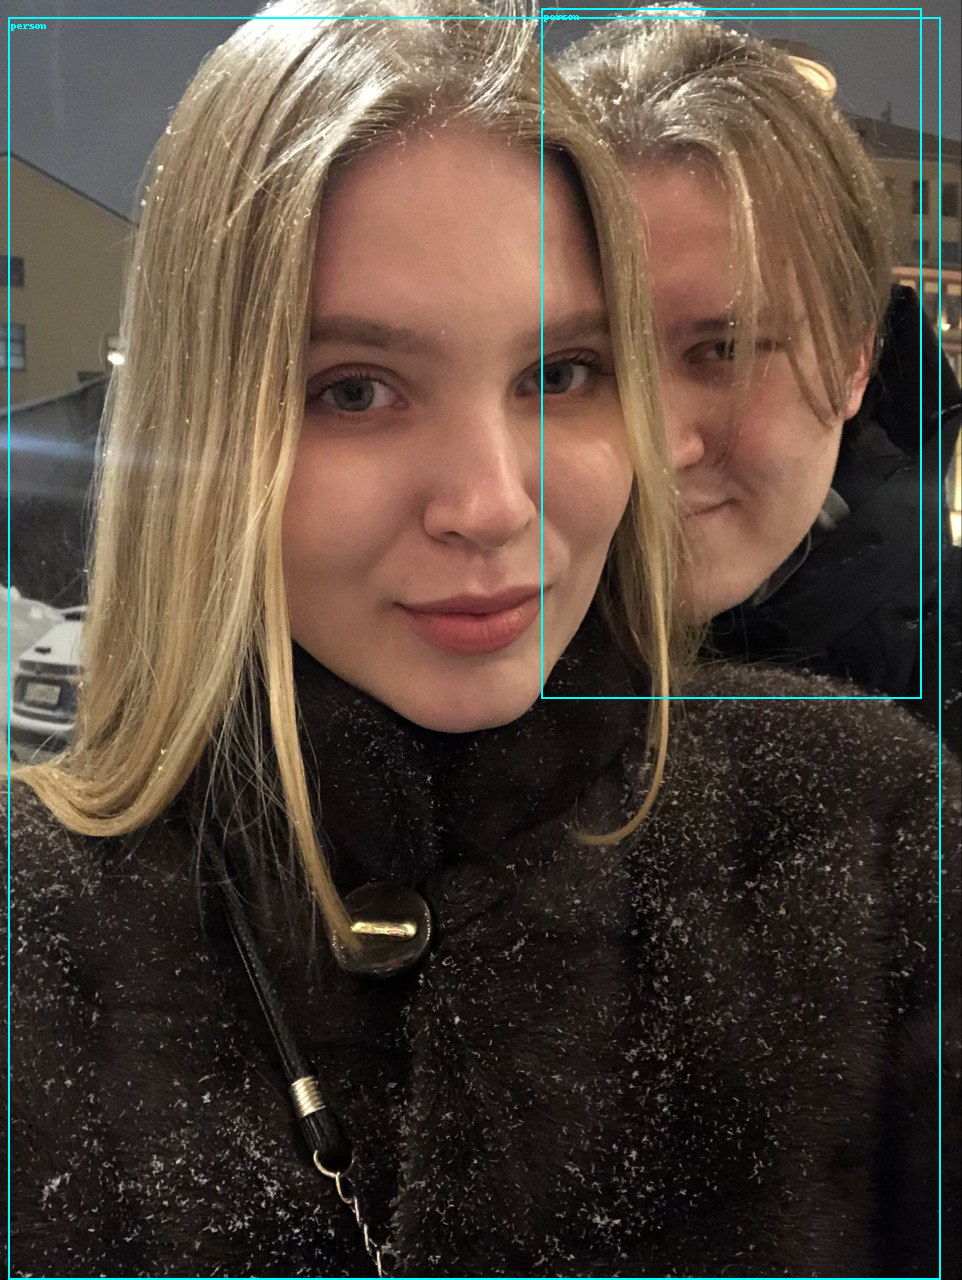

In [ ]:
to_pil_image(box)

## Resume:
➕Плюсы: высокая точность и уверенность модели в прогнозах (>0,96); FasterRCNN_ResNet50_FPN_V2 обнаруживает с высокой вероятностью человека лишь по части лица в отличие от yolo

➖Минусы: долгая обработка; отсутствие настраиваемых параметров помимо классов

## Сравнение версий
### ✅FasterRCNN_ResNet50_V2
🏅Распознала второе лицо

Уверенность: 0.97+

Скорость: **total 13.6 s**
### ✅FasterRCNN_MobileNet_V3_Large
Уверенность: 0.99, но не распознал второе лицо

Скорость: **total: 1.81 s**
### ✅FasterRCNN_MobileNet_V3_Large_320
Уверенность: 0.99, но распознал два лица за одно (bbox шире)

Скорость: **total: 751 ms**

#3. Группа сетей  RetinaNet

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

In [ ]:
weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
model = retinanet_resnet50_fpn_v2(weights=weights, score_thresh=0.35)
model.eval()
preprocess = weights.transforms()

In [ ]:
img_path = '/content/we.jpg'
img = read_image(img_path)

batch = [preprocess(img)]

In [ ]:
weights.meta["categories"] = weights.meta["categories"][0:2]
weights.meta["categories"]

['__background__', 'person']

In [ ]:
%%time
prediction = model(batch)[0]
prediction["boxes"] = prediction["boxes"][prediction["scores"] > 0.9]
prediction["labels"] = prediction["labels"][prediction["scores"] > 0.9]
prediction["scores"] = prediction["scores"][prediction["scores"] > 0.9]

labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="cyan",
                          width=2, 
                          font_size = 30)

res = Image.fromarray(box.permute(1, 2, 0).contiguous().numpy())
res.save("bbox_retina.png")

CPU times: user 7.34 s, sys: 350 ms, total: 7.69 s
Wall time: 7.7 s


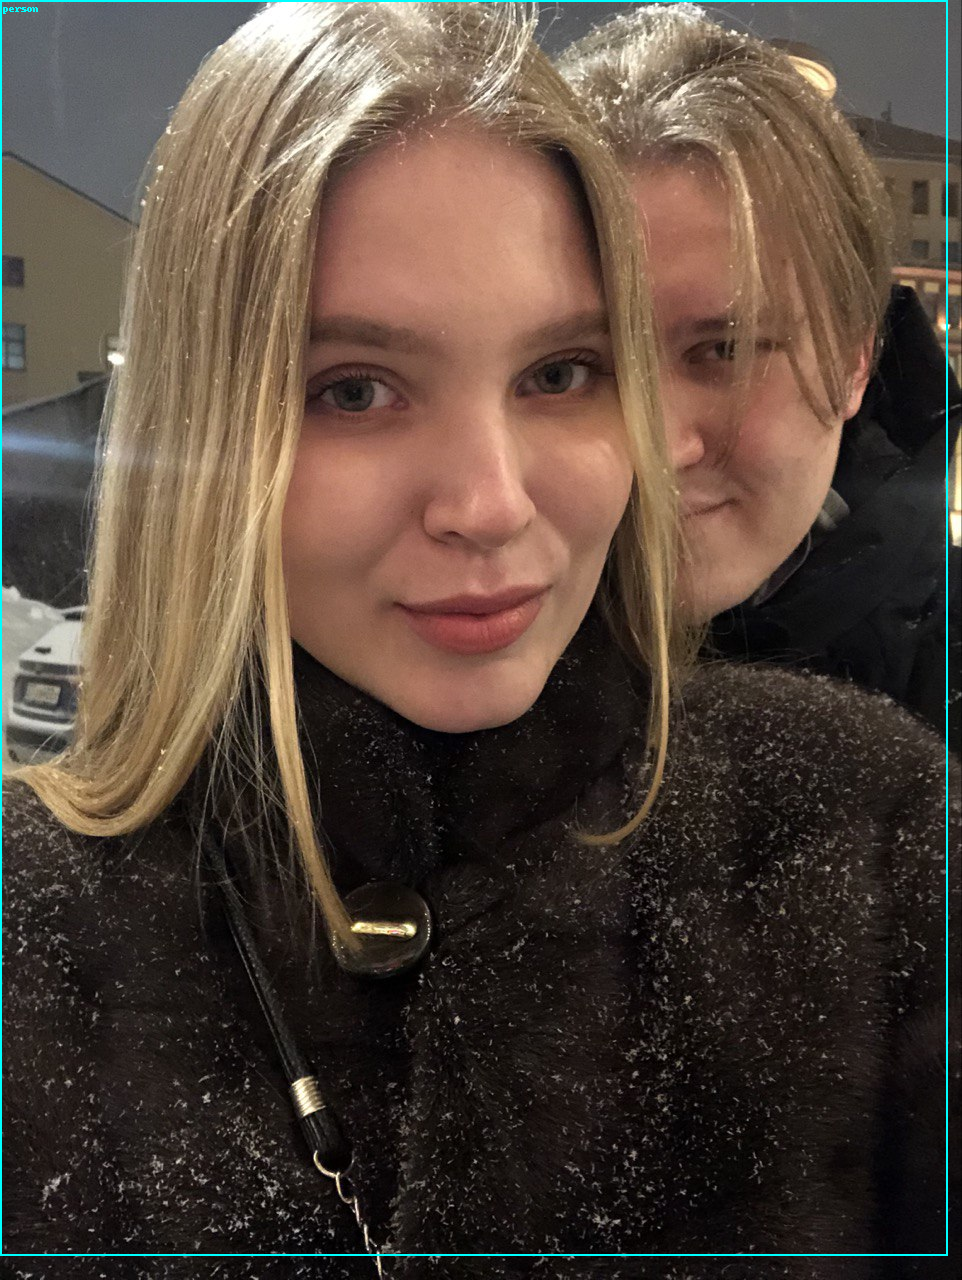

In [ ]:
to_pil_image(box)

## Resume:
➕Плюсы: высокая уверенность модели в проигнозируемом объекте, но ниже, чем у FasterRCNN

➖Минусы: не обнаружен второй объект; затраченное время не соответствует качеству

## Сравнение версий
### ✅RetinaNet_ResNet50_FPN_V2
Уверенность: 0.94

Скорость: **total: 7.69 s**

# Выводы проведенного исследования

*   Были исследованы 4 основные архитектуры нейронных сетей для задачи детекции объектов
*   По соотношению время/качество лучше всего себя показала сеть Yolo v5l, позволяющая за пару секунд обнаружить все объекты даже по их части
*   В исследовательском ноутбуке показаны результаты работы на CPU. В случае же подключения GPU суммарное время работы модели будет уменьшено в 4 раза
*   Для дальнейшего дообучения модели необходимо учитывать не только параметры confidence и time, но и количество параметров архитектуры нейронной сети, чтобы ее обучение не заняло неделю

